In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from scipy.interpolate import UnivariateSpline
import statsmodels.api as sm
import matplotlib.pyplot as plt
import collections

pd.set_option("display.max_column", 999)

In [5]:
def prepare_data(df):
    df['WFG_ratio'] = df['WFGM'] / df['WFGA'] * 100
    df['WFT_ratio'] = df['WFTM'] / df['WFTA'] * 100
    df['WATO_ratio'] = df['WAst'] / df['WTO'] * 100
    
    df['LFG_ratio'] = df['LFGM'] / df['LFGA'] * 100
    df['LFT_ratio'] = df['LFTM'] / df['LFTA'] * 100
    df['LATO_ratio'] = df['LAst'] / df['LTO'] * 100
    
    df = df[['Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT',
            'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF',
            'WFG_ratio','WFT_ratio','WATO_ratio',
            'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF',
            'LFG_ratio','LFT_ratio','LATO_ratio']]
    
    dfswap = df[['Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 
                 'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF',
                 'LFG_ratio','LFT_ratio','LATO_ratio',
                 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF',
                 'WFG_ratio','WFT_ratio','WATO_ratio']]

    dfswap.loc[df['WLoc'] == 'H', 'WLoc'] = 'A'
    dfswap.loc[df['WLoc'] == 'A', 'WLoc'] = 'H'
    df.columns.values[6] = 'location'
    dfswap.columns.values[6] = 'location'    
      
    df.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(df.columns)]
    dfswap.columns = [x.replace('L','T1_').replace('W','T2_') for x in list(dfswap.columns)]

    output = pd.concat([df, dfswap]).reset_index(drop=True)
    output.loc[output.location=='N','location'] = '0'
    output.loc[output.location=='H','location'] = '1'
    output.loc[output.location=='A','location'] = '-1'
    output.location = output.location.astype(int)
    
    output['PointDiff'] = output['T1_Score'] - output['T2_Score']
    
    return output

In [235]:
tourney_results = pd.read_csv('stage2/NCAATourneyDetailedResults.csv')
seeds = pd.read_csv('stage2/NCAATourneySeeds.csv')
regular_results = pd.read_csv('stage2/RegularSeasonDetailedResults.csv')

In [236]:
regular_data = prepare_data(regular_results)
tourney_data = prepare_data(tourney_results)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [276]:
# boxscore_cols = ['T1_Score', 'T2_Score', 
#         'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_FTM', 'T1_FTA', 'T1_OR', 'T1_DR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_Blk', 'T1_PF', 
#         'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_FTM', 'T2_FTA', 'T2_OR', 'T2_DR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF', 
#         'PointDiff']

boxscore_cols = ['T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_FTM', 'T1_FTA','T1_OR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_PF',
                 'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_FTM', 'T2_FTA','T2_OR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_PF','PointDiff',
                 'T1_FG_ratio','T1_FT_ratio',
                 'T2_FG_ratio','T2_FT_ratio']

funcs = [np.mean] 

In [277]:
season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs).reset_index()
season_statistics.columns = [''.join(col).strip() for col in season_statistics.columns.values]
season_statistics.head()

,Season,T1_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_FTMmean,T1_FTAmean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_FTMmean,T2_FTAmean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,PointDiffmean,T1_FG_ratiomean,T1_FT_ratiomean,T2_FG_ratiomean,T2_FT_ratiomean
0,2003,1102,19.142857,39.785714,7.821429,20.821429,11.142857,17.107143,4.178571,13.000000,11.428571,5.964286,18.750000,19.285714,42.428571,4.750000,12.428571,13.678571,19.250000,9.607143,9.142857,12.964286,5.428571,18.357143,0.250000,48.614901,64.240191,45.803814,71.946206
1,2003,1103,27.148148,55.851852,5.444444,16.074074,19.037037,25.851852,9.777778,15.222222,12.629630,7.259259,19.851852,27.777778,57.000000,6.666667,18.370370,15.925926,22.148148,12.037037,15.481481,15.333333,6.407407,22.444444,0.629630,48.729380,73.527072,49.004403,73.566071
2,2003,1104,24.035714,57.178571,6.357143,19.857143,14.857143,20.928571,13.571429,12.107143,13.285714,6.607143,18.035714,23.250000,55.500000,6.357143,19.142857,12.142857,17.142857,10.892857,11.678571,13.857143,5.535714,19.250000,4.285714,41.967640,70.516772,42.239736,71.259663
3,2003,1105,24.384615,61.615385,7.576923,20.769231,15.423077,21.846154,13.500000,14.538462,18.653846,9.307692,20.230769,27.000000,58.961538,6.269231,17.538462,16.384615,24.500000,13.192308,15.807692,18.807692,9.384615,19.076923,-4.884615,39.620409,70.959802,45.648213,66.971600
4,2003,1106,23.428571,55.285714,6.107143,17.642857,10.642857,16.464286,12.285714,11.678571,17.035714,8.357143,18.178571,21.714286,53.392857,4.785714,15.214286,15.535714,21.964286,11.321429,11.785714,15.071429,8.785714,16.142857,-0.142857,42.552963,62.315765,40.854865,71.173321


In [278]:
season_statistics_T1 = season_statistics.copy()
season_statistics_T2 = season_statistics.copy()

season_statistics_T1.columns = ["T1_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T1.columns)]
season_statistics_T2.columns = ["T2_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T2.columns)]
season_statistics_T1.columns.values[0] = "Season"
season_statistics_T2.columns.values[0] = "Season"

In [279]:
tourney_data = tourney_data[['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID' ,'T2_Score']]
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score
0,2003,134,1421,92,1411,84
1,2003,136,1112,80,1436,51
2,2003,136,1113,84,1272,71
3,2003,136,1141,79,1166,73
4,2003,136,1143,76,1301,74


In [280]:
tourney_data = pd.merge(tourney_data, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [281]:
### check ratio
last14days_stats_T1 = regular_data.loc[regular_data.DayNum>118].reset_index(drop=True)
last14days_stats_T1['win'] = np.where(last14days_stats_T1['PointDiff']>0,1,0)
last14days_stats_T1 = last14days_stats_T1.groupby(['Season','T1_TeamID'])['win'].mean().reset_index(name='T1_win_ratio_14d')

last14days_stats_T2 = regular_data.loc[regular_data.DayNum>118].reset_index(drop=True)
last14days_stats_T2['win'] = np.where(last14days_stats_T2['PointDiff']<0,1,0)
last14days_stats_T2 = last14days_stats_T2.groupby(['Season','T2_TeamID'])['win'].mean().reset_index(name='T2_win_ratio_14d')

In [282]:
tourney_data = pd.merge(tourney_data, last14days_stats_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, last14days_stats_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [283]:
regular_season_effects = regular_data[['Season','T1_TeamID','T2_TeamID','PointDiff']].copy()
regular_season_effects['T1_TeamID'] = regular_season_effects['T1_TeamID'].astype(str)
regular_season_effects['T2_TeamID'] = regular_season_effects['T2_TeamID'].astype(str)
regular_season_effects['win'] = np.where(regular_season_effects['PointDiff']>0,1,0)
march_madness = pd.merge(seeds[['Season','TeamID']],seeds[['Season','TeamID']],on='Season')
march_madness.columns = ['Season', 'T1_TeamID', 'T2_TeamID']
march_madness.T1_TeamID = march_madness.T1_TeamID.astype(str)
march_madness.T2_TeamID = march_madness.T2_TeamID.astype(str)
regular_season_effects = pd.merge(regular_season_effects, march_madness, on = ['Season','T1_TeamID','T2_TeamID'])
regular_season_effects.shape

(9914, 5)

In [284]:
def team_quality(season):
    formula = 'win~-1+T1_TeamID+T2_TeamID'
    glm = sm.GLM.from_formula(formula=formula, 
                              data=regular_season_effects.loc[regular_season_effects.Season==season,:], 
                              family=sm.families.Binomial()).fit()
    
    quality = pd.DataFrame(glm.params).reset_index()
    quality.columns = ['TeamID','quality']
    quality['Season'] = season
    quality['quality'] = np.exp(quality['quality'])
    quality = quality.loc[quality.TeamID.str.contains('T1_')].reset_index(drop=True)
    quality['TeamID'] = quality['TeamID'].apply(lambda x: x[10:14]).astype(int)
    return quality

In [285]:
glm_quality = pd.concat([team_quality(2010),
                         team_quality(2011),
                         team_quality(2012),
                         team_quality(2013),
                         team_quality(2014),
                         team_quality(2015),
                         team_quality(2016),
                         team_quality(2017),
                         team_quality(2018),
                         team_quality(2019)]).reset_index(drop=True)


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:880: RuntimeWarning: invalid value encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:879: RuntimeWarning: invalid value encountered in true_divide
  endog_mu = self._clean(endog / mu)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:879: RuntimeWarning: divide by zero encountered in true_divide
  endog_mu = self._clean(endog / mu)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:880: RuntimeWarning: divide by zero encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))


In [286]:
glm_quality_T1 = glm_quality.copy()
glm_quality_T2 = glm_quality.copy()
glm_quality_T1.columns = ['T1_TeamID','T1_quality','Season']
glm_quality_T2.columns = ['T2_TeamID','T2_quality','Season']

In [287]:
tourney_data = pd.merge(tourney_data, glm_quality_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, glm_quality_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [288]:
seeds['seed'] = seeds['Seed'].apply(lambda x: int(x[1:3]))
seeds['division'] = seeds['Seed'].apply(lambda x: x[0])
seeds.head()

,Season,Seed,TeamID,seed,division
0,1985,W01,1207,1,W
1,1985,W02,1210,2,W
2,1985,W03,1228,3,W
3,1985,W04,1260,4,W
4,1985,W05,1374,5,W


In [289]:
seeds_T1 = seeds[['Season','TeamID','seed','division']].copy()
seeds_T2 = seeds[['Season','TeamID','seed','division']].copy()
seeds_T1.columns = ['Season','T1_TeamID','T1_seed','T1_division']
seeds_T2.columns = ['Season','T2_TeamID','T2_seed','T2_division']

In [290]:
tourney_data = pd.merge(tourney_data, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [291]:
tourney_data['T1_powerrank'] = tourney_data.groupby(['Season','T1_division'])['T1_quality'].rank(method='dense', ascending=False)
tourney_data['T2_powerrank'] = tourney_data.groupby(['Season','T2_division'])['T2_quality'].rank(method='dense', ascending=False)
tourney_data = tourney_data.drop(['T1_division','T2_division'], axis = 1)

In [292]:
top4_data  = pd.merge(regular_data , seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
top4_data  = pd.merge(regular_data, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')

top4_data['score_difference_top4'] = top4_data['T1_Score'] - top4_data['T2_Score']
top4_data['seed_top4'] = 0
top4_data = top4_data.loc[top4_data.T2_seed <= 4]
top4_data.loc[(top4_data.T2_seed <= 4) & (top4_data.T1_Score > top4_data.T2_Score), 'seed_top4'] = 1

agg_func = {
    'score_difference_top4' : ['mean'],
    'seed_top4' : ['mean'],
}
top4 = top4_data.groupby(['Season','T1_TeamID']).agg(agg_func).reset_index()
top4.columns = [''.join(col).strip() for col in top4.columns.values]

top4_T1 = top4.copy()
top4_T2 = top4.copy()

top4_T1.columns = ["T1_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(top4_T1.columns)]
top4_T2.columns = ["T2_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(top4_T2.columns)]
top4_T1.columns.values[0] = "Season"
top4_T2.columns.values[0] = "Season"

tourney_data = pd.merge(tourney_data, top4_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, top4_T2, on = ['Season', 'T2_TeamID'], how = 'left')

tourney_data = tourney_data.fillna(0)

In [293]:
top8_data  = pd.merge(regular_data , seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
top8_data  = pd.merge(regular_data, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')

top8_data['score_difference_top8'] = top8_data['T1_Score'] - top8_data['T2_Score']
top8_data['seed_top8'] = 0
top8_data = top8_data.loc[(top8_data.T2_seed <= 8) & (top8_data.T2_seed > 4)]
top8_data.loc[(top8_data.T1_Score > top8_data.T2_Score), 'seed_top8'] = 1
top8_data.head()

agg_func = {
    'score_difference_top8' : ['mean'],
    'seed_top8' : ['mean'],
}
top8 = top8_data.groupby(['Season','T1_TeamID']).agg(agg_func).reset_index()
top8.columns = [''.join(col).strip() for col in top8.columns.values]

top8_T1 = top8.copy()
top8_T2 = top8.copy()

top8_T1.columns = ["T1_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(top8_T1.columns)]
top8_T2.columns = ["T2_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(top8_T2.columns)]
top8_T1.columns.values[0] = "Season"
top8_T2.columns.values[0] = "Season"

tourney_data = pd.merge(tourney_data, top8_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, top8_T2, on = ['Season', 'T2_TeamID'], how = 'left')

tourney_data = tourney_data.fillna(0)

In [294]:
tourney_data["Seed_diff"] = tourney_data["T1_seed"] - tourney_data["T2_seed"]

In [295]:
kenpom = pd.read_csv("kenpom.csv")
kenpom .Team = kenpom .Team.str.lower()
name = pd.read_csv('datafiles/TeamSpellings.csv', encoding = "ISO-8859-1")
name.columns = ['Team','TeamID']
kenpom = kenpom.merge(name, on = 'Team')
kenpom = kenpom[['Year','Rank','Pyth','TeamID']]

kenpom_T1 = kenpom.copy()
kenpom_T2 = kenpom.copy()

kenpom_T1.columns = ["T1_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(kenpom_T1.columns)]
kenpom_T2.columns = ["T2_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(kenpom_T2.columns)]
kenpom_T1.columns.values[0] = "Season"
kenpom_T2.columns.values[0] = "Season"

In [296]:
tourney_data = pd.merge(tourney_data, kenpom_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, kenpom_T2, on = ['Season', 'T2_TeamID'], how = 'left')

tourney_data["Pyth_diff"] = tourney_data["T1_Pyth"] - tourney_data["T2_Pyth"]
tourney_data["Rank_diff"] = tourney_data["T1_Rank"] - tourney_data["T2_Rank"]

In [297]:
y = tourney_data['T1_Score'] - tourney_data['T2_Score']
y.describe()

count    2096.00000
mean        0.00000
std        14.28837
min       -56.00000
25%       -10.00000
50%         0.00000
75%        10.00000
max        56.00000
dtype: float64

In [444]:
features = list(season_statistics_T1.columns[2:999]) + \
    list(season_statistics_T2.columns[2:999]) + \
    list(seeds_T1.columns[2:3]) + \
    list(seeds_T2.columns[2:3]) + \
    list(last14days_stats_T1.columns[2:999]) + \
    list(last14days_stats_T2.columns[2:999]) + \
    ["Seed_diff"] + ['T1_powerrank'] + ['T2_powerrank'] #+ ["Pyth_diff"] + ["Rank_diff"]# \ ["T1_quality","T2_quality"] + \

#     list(top4_T1.columns[2:999]) + \
#     list(top4_T2.columns[2:999]) + \
#     list(top8_T1.columns[2:999]) + \
#     list(top8_T2.columns[2:999]) + \
len(features)

69

### XGB

In [445]:
X = tourney_data[features].values
dtrain = xgb.DMatrix(X, label = y)

In [446]:
def cauchyobj(preds, dtrain):
    labels = dtrain.get_label()
    c = 5000 
    x =  preds-labels    
    grad = x / (x**2/c**2+1)
    hess = -c**2*(x**2-c**2)/(x**2+c**2)**2
    return grad, hess

In [447]:
param = {} 
#param['objective'] = 'reg:linear'
param['eval_metric'] =  'mae'
param['booster'] = 'gbtree'
param['eta'] = 0.02 #change to ~0.02 for final run
param['subsample'] = 0.35
param['colsample_bytree'] = 0.7
param['num_parallel_tree'] = 8 #recommend 10
param['min_child_weight'] = 40
param['gamma'] = 10
param['max_depth'] =  3
param['silent'] = 1

print(param)

{'eval_metric': 'mae', 'booster': 'gbtree', 'eta': 0.02, 'subsample': 0.35, 'colsample_bytree': 0.7, 'num_parallel_tree': 8, 'min_child_weight': 40, 'gamma': 10, 'max_depth': 3, 'silent': 1}


In [448]:
xgb_cv = []
repeat_cv = 10

for i in range(repeat_cv): 
    print(f"Fold repeater {i}")
    xgb_cv.append(
        xgb.cv(
          params = param,
          dtrain = dtrain,
          obj = cauchyobj,
          num_boost_round = 3000,
          folds = KFold(n_splits = 10, shuffle = True, random_state = i),
          early_stopping_rounds = 25,
          verbose_eval = 50
        )
    )


Fold repeater 0
[0]	train-mae:11.3311+0.0654633	test-mae:11.3344+0.594121
[50]	train-mae:9.17339+0.0480403	test-mae:9.35322+0.55319
[100]	train-mae:8.58021+0.0413161	test-mae:8.93497+0.45899
[150]	train-mae:8.30732+0.040679	test-mae:8.80977+0.422387
[200]	train-mae:8.11878+0.0399318	test-mae:8.76952+0.404886
[250]	train-mae:7.96244+0.0437787	test-mae:8.74929+0.405792
[300]	train-mae:7.82212+0.0462474	test-mae:8.74205+0.404649
Fold repeater 1
[0]	train-mae:11.3304+0.0482328	test-mae:11.3338+0.432141
[50]	train-mae:9.17389+0.0582771	test-mae:9.33877+0.484137
[100]	train-mae:8.58158+0.0529001	test-mae:8.92351+0.452869
[150]	train-mae:8.3092+0.0482729	test-mae:8.81071+0.418446
[200]	train-mae:8.11912+0.0460103	test-mae:8.77904+0.392743
[250]	train-mae:7.96336+0.0462317	test-mae:8.7604+0.382441
[300]	train-mae:7.8239+0.0458725	test-mae:8.75082+0.369493
[350]	train-mae:7.69308+0.0461106	test-mae:8.74916+0.363358
Fold repeater 2
[0]	train-mae:11.3301+0.0580222	test-mae:11.3333+0.52739
[50]	tr

In [449]:
iteration_counts = [np.argmin(x['test-mae-mean'].values) for x in xgb_cv]
val_mae = [np.min(x['test-mae-mean'].values) for x in xgb_cv]
iteration_counts, val_mae

([324, 337, 255, 297, 353, 362, 416, 437, 302, 363],
 [8.738064900000001,
  8.747669399999998,
  8.792645799999999,
  8.7896249,
  8.752205900000002,
  8.7438309,
  8.7523133,
  8.746904,
  8.7565737,
  8.7436786])

In [450]:
oof_preds = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    preds = y.copy()
    kfold = KFold(n_splits = 10, shuffle = True, random_state = i)    
    for train_index, val_index in kfold.split(X,y):
        dtrain_i = xgb.DMatrix(X[train_index], label = y[train_index])
        dval_i = xgb.DMatrix(X[val_index], label = y[val_index])  
        model = xgb.train(
              params = param,
              dtrain = dtrain_i,
              num_boost_round = iteration_counts[i],
              verbose_eval = 50
        )
        preds[val_index] = model.predict(dval_i)
    oof_preds.append(np.clip(preds,-30,30))

Fold repeater 0
Fold repeater 1
Fold repeater 2
Fold repeater 3
Fold repeater 4
Fold repeater 5
Fold repeater 6
Fold repeater 7
Fold repeater 8
Fold repeater 9


### LGB

In [266]:
X = tourney_data[features].values
dtrain = lgb.Dataset(X, label = y)

In [29]:
params = {}
params['max_bin'] = 300
params['learning_rate'] = 0.021 # shrinkage_rate
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression_l1'
params['metric'] = 'mae'          # or 'mae'
params['sub_feature'] = 0.5      # feature_fraction (small values => use very different submodels)
params['bagging_fraction'] = 0.85 # sub_row
params['bagging_freq'] = 40
params['num_leaves'] = 70        # num_leaf
params['min_data'] = 100         # min_data_in_leaf
params['verbose'] = 0
params['feature_fraction_seed'] = 2
params['bagging_seed'] = 3

In [ ]:
lgb_cv = []
repeat_cv = 5 # recommend 10

for i in range(repeat_cv): 
    print(f"Fold repeater {i}")
    lgb_cv.append(
        lgb.cv(
          params,
          dtrain,
#          objective = cauchyobj,
          num_boost_round = 3000,
          folds = KFold(n_splits = 5, shuffle = True, random_state = i),
          early_stopping_rounds = 50,
          verbose_eval = 200
        )
    )


In [ ]:
iteration_counts = [np.argmin(x["l1-mean"]) for x in lgb_cv]
iteration_counts

In [32]:
oof_preds = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    preds = y.copy()
    kfold = KFold(n_splits = 5, shuffle = True, random_state = i)    
    for train_index, val_index in kfold.split(X,y):
        dtrain_i = lgb.Dataset(X[train_index], label = y[train_index])
        dval_i = lgb.Dataset(X[val_index], label = y[val_index])  
        model = lgb.train(
              params,
              dtrain_i,
              num_boost_round = iteration_counts[i],
              verbose_eval = 100
        )
        preds[val_index] = model.predict(X[val_index])
    oof_preds.append(np.clip(preds,-30,30))

Fold repeater 0
Fold repeater 1
Fold repeater 2
Fold repeater 3
Fold repeater 4
Fold repeater 5
Fold repeater 6
Fold repeater 7
Fold repeater 8
Fold repeater 9


### Plotting

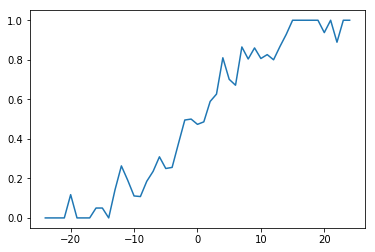

In [451]:
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0)})
plot_df["pred_int"] = plot_df["pred"].astype(int)
plot_df = plot_df.groupby('pred_int')['label'].mean().reset_index(name='average_win_pct')

plt.figure()
plt.plot(plot_df.pred_int,plot_df.average_win_pct)

In [452]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
        
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    
    print(f"logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

logloss of cvsplit 0: 0.543949659933055
logloss of cvsplit 1: 0.5448011327805562
logloss of cvsplit 2: 0.5468845291573562
logloss of cvsplit 3: 0.5478941352423153
logloss of cvsplit 4: 0.5452791473736692
logloss of cvsplit 5: 0.5462802781802995
logloss of cvsplit 6: 0.544123000171465
logloss of cvsplit 7: 0.5458998939276216
logloss of cvsplit 8: 0.5453501099204472
logloss of cvsplit 9: 0.5449707801800833


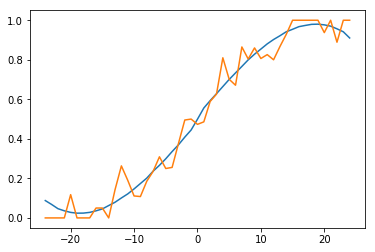

In [453]:
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0), "spline":spline_model[0](oof_preds[0])})
plot_df["pred_int"] = (plot_df["pred"]).astype(int)
plot_df = plot_df.groupby('pred_int')['spline','label'].mean().reset_index()

plt.figure()
plt.plot(plot_df.pred_int,plot_df.spline)
plt.plot(plot_df.pred_int,plot_df.label)

In [454]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 0.5440121856826223
adjusted logloss of cvsplit 1: 0.5448137697370139
adjusted logloss of cvsplit 2: 0.5468850876052151
adjusted logloss of cvsplit 3: 0.5478941352423153
adjusted logloss of cvsplit 4: 0.5452684603657157
adjusted logloss of cvsplit 5: 0.5463584274559931
adjusted logloss of cvsplit 6: 0.5441652805687982
adjusted logloss of cvsplit 7: 0.5459789242394993
adjusted logloss of cvsplit 8: 0.5453464887255375
adjusted logloss of cvsplit 9: 0.5450998641134362


In [455]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16)] = 1.0
    spline_fit[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15)] = 1.0
    spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1)] = 0.0
    spline_fit[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2)] = 0.0
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 0.6905998792531975
adjusted logloss of cvsplit 1: 0.6916943762041745
adjusted logloss of cvsplit 2: 0.693245641039937
adjusted logloss of cvsplit 3: 0.6942647587675608
adjusted logloss of cvsplit 4: 0.6922504078115284
adjusted logloss of cvsplit 5: 0.6931219439980303
adjusted logloss of cvsplit 6: 0.6912223832995991
adjusted logloss of cvsplit 7: 0.6929472264520616
adjusted logloss of cvsplit 8: 0.691878192197544
adjusted logloss of cvsplit 9: 0.6917464152992044


In [456]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 0.5393304151715396
adjusted logloss of cvsplit 1: 0.5398993014995344
adjusted logloss of cvsplit 2: 0.5420397749533206
adjusted logloss of cvsplit 3: 0.5427241221754736
adjusted logloss of cvsplit 4: 0.5406345457783236
adjusted logloss of cvsplit 5: 0.5415165547962906
adjusted logloss of cvsplit 6: 0.5392031899416934
adjusted logloss of cvsplit 7: 0.5410248713626706
adjusted logloss of cvsplit 8: 0.5405002432594184
adjusted logloss of cvsplit 9: 0.5404155638789706


In [457]:
val_cv = []
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)

    spline_fit[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    
    spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed<=8) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==2) & (tourney_data.T2_seed<=8) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    
    spline_fit[(tourney_data.T1_seed<=8) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed<=8) & (tourney_data.T2_seed==2) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    
    
    
    val_cv.append(pd.DataFrame({"y":np.where(y>0,1,0), "pred":spline_fit, "season":tourney_data.Season}))
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 
    
val_cv = pd.concat(val_cv)
val_cv.groupby('season').apply(lambda x: log_loss(x.y, x.pred))

adjusted logloss of cvsplit 0: 0.4658406604903093
adjusted logloss of cvsplit 1: 0.467108920654058
adjusted logloss of cvsplit 2: 0.4679347049145738
adjusted logloss of cvsplit 3: 0.46847445421480316
adjusted logloss of cvsplit 4: 0.4664003862651312
adjusted logloss of cvsplit 5: 0.4673806057686156
adjusted logloss of cvsplit 6: 0.46597150987474917
adjusted logloss of cvsplit 7: 0.4668752546676036
adjusted logloss of cvsplit 8: 0.466757511589564
adjusted logloss of cvsplit 9: 0.4667140952149683


season
2003    0.496427
2004    0.438893
2005    0.418403
2006    0.502518
2007    0.312376
2008    0.384467
2009    0.380398
2010    0.507737
2011    0.580707
2012    0.477830
2013    0.534521
2014    0.535029
2015    0.463298
2016    0.459351
2017    0.430567
2018    0.535432
dtype: float64

In [459]:
np.mean(val_cv.groupby('season').apply(lambda x: log_loss(x.y, x.pred))) #0.45783709005144907

0.4661220777330336

## Submission

In [422]:
sub = pd.read_csv('stage2/SampleSubmissionStage2.csv')
sub.head()

,ID,Pred
0,2019_1101_1113,0.5
1,2019_1101_1120,0.5
2,2019_1101_1124,0.5
3,2019_1101_1125,0.5
4,2019_1101_1133,0.5


In [423]:
sub['Season'] = sub['ID'].map(lambda x: x.split('_')[0])
sub['Season'] = sub['Season'].astype(int)
sub["T1_TeamID"] = sub["ID"].apply(lambda x: x[5:9]).astype(int)
sub["T2_TeamID"] = sub["ID"].apply(lambda x: x[10:14]).astype(int)

In [424]:
sub = pd.merge(sub, kenpom_T1, on = ['Season', 'T1_TeamID'], how = 'left')
sub = pd.merge(sub, kenpom_T2, on = ['Season', 'T2_TeamID'], how = 'left')

sub["Pyth_diff"] = sub["T1_Pyth"] - sub["T2_Pyth"]
sub["Rank_diff"] = sub["T1_Rank"] - sub["T2_Rank"]

In [425]:
sub = pd.merge(sub, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
sub = pd.merge(sub, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')
sub = pd.merge(sub, glm_quality_T1, on = ['Season', 'T1_TeamID'], how='left')
sub = pd.merge(sub, glm_quality_T2, on = ['Season', 'T2_TeamID'], how='left')
sub = pd.merge(sub, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
sub = pd.merge(sub, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')
sub = pd.merge(sub, last14days_stats_T1, on = ['Season', 'T1_TeamID'], how = 'left')
sub = pd.merge(sub, last14days_stats_T2, on = ['Season', 'T2_TeamID'], how = 'left')
sub = pd.merge(sub, top4_T1, on = ['Season', 'T1_TeamID'], how = 'left')
sub = pd.merge(sub, top4_T2, on = ['Season', 'T2_TeamID'], how = 'left')
sub = pd.merge(sub, top8_T1, on = ['Season', 'T1_TeamID'], how = 'left')
sub = pd.merge(sub, top8_T2, on = ['Season', 'T2_TeamID'], how = 'left') 
sub["Seed_diff"] = sub["T1_seed"] - sub["T2_seed"]
sub = sub.fillna(0)
sub.head()

,ID,Pred,Season,T1_TeamID,T2_TeamID,T1_Rank,T1_Pyth,T2_Rank,T2_Pyth,Pyth_diff,Rank_diff,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_FTMmean,T1_FTAmean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_FTMmean,T1_opponent_FTAmean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_PFmean,T1_PointDiffmean,T1_FG_ratiomean,T1_FT_ratiomean,T1_opponent_FG_ratiomean,T1_opponent_FT_ratiomean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_FTMmean,T2_FTAmean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_FTMmean,T2_opponent_FTAmean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_PFmean,T2_PointDiffmean,T2_FG_ratiomean,T2_FT_ratiomean,T2_opponent_FG_ratiomean,T2_opponent_FT_ratiomean,T1_quality,T2_quality,T1_seed,T1_division,T2_seed,T2_division,T1_win_ratio_14d,T2_win_ratio_14d,T1_score_difference_top4mean,T1_seed_top4mean,T2_score_difference_top4mean,T2_seed_top4mean,T1_score_difference_top8mean,T1_seed_top8mean,T2_score_difference_top8mean,T2_seed_top8mean,Seed_diff
0,2019_1101_1113,0.5,2019,1101,1113,0.0,0.0,0.0,0.00,0.0,0.0,25.344828,55.241379,7.241379,18.896552,13.793103,19.068966,9.068966,14.62069,11.655172,8.0,19.137931,22.482759,51.137931,5.724138,17.103448,14.206897,19.655172,8.827586,11.103448,15.724138,5.551724,18.068966,6.827586,45.886076,72.648828,44.121238,69.568047,26.593750,59.468750,7.250000,21.250000,17.375000,25.906250,12.156250,13.593750,13.593750,6.218750,19.906250,24.218750,58.687500,8.562500,25.500000,16.062500,22.656250,10.000000,13.281250,13.906250,6.343750,21.656250,4.750000,45.093675,66.807196,41.291244,70.692864,0.003991,8.904502e+14,15,Y,11,X,1.0,0.666667,-34.0,0.0,4.000000,1.000000,0.0,0.0,1.333333,0.666667,4
1,2019_1101_1120,0.5,2019,1101,1120,0.0,0.0,13.0,23.25,0.0,0.0,25.344828,55.241379,7.241379,18.896552,13.793103,19.068966,9.068966,14.62069,11.655172,8.0,19.137931,22.482759,51.137931,5.724138,17.103448,14.206897,19.655172,8.827586,11.103448,15.724138,5.551724,18.068966,6.827586,45.886076,72.648828,44.121238,69.568047,27.029412,60.441176,11.411765,29.970588,13.411765,18.735294,11.735294,14.411765,12.147059,9.294118,18.382353,23.235294,52.941176,8.323529,23.382353,13.794118,19.352941,10.764706,12.029412,17.588235,5.911765,17.205882,10.294118,44.757887,69.903428,44.012360,71.912585,0.003991,5.055346e+14,15,Y,5,Y,1.0,1.000000,-34.0,0.0,-2.666667,0.333333,0.0,0.0,-5.750000,0.250000,10
2,2019_1101_1124,0.5,2019,1101,1124,0.0,0.0,41.0,15.24,0.0,0.0,25.344828,55.241379,7.241379,18.896552,13.793103,19.068966,9.068966,14.62069,11.655172,8.0,19.137931,22.482759,51.137931,5.724138,17.103448,14.206897,19.655172,8.827586,11.103448,15.724138,5.551724,18.068966,6.827586,45.886076,72.648828,44.121238,69.568047,25.500000,57.906250,7.937500,23.375000,12.718750,18.875000,13.375000,13.843750,13.281250,6.125000,18.781250,23.218750,55.031250,7.093750,20.781250,13.656250,20.093750,9.968750,12.843750,12.406250,5.968750,18.031250,4.468750,44.208138,66.343731,42.376092,67.490486,0.003991,7.174120e+14,15,Y,9,X,1.0,0.000000,-34.0,0.0,-6.666667,0.166667,0.0,0.0,-4.500000,0.500000,6
3,2019_1101_1125,0.5,2019,1101,1125,0.0,0.0,0.0,0.00,0.0,0.0,25.344828,55.241379,7.241379,18.896552,13.793103,19.068966,9.068966,14.62069,11.655172,8.0,19.137931,22.482759,51.137931,5.724138,17.103448,14.206897,19.655172,8.827586,11.103448,15.724138,5.551724,18.068966,6.827586,45.886076,72.648828,44.121238,69.568047,31.666667,63.733333,10.366667,27.966667,13.166667,17.900000,8.900000,19.600000,11.600000,6.666667,15.700000,27.333333,63.766667,7.666667,22.133333,12.333333,17.666667,9.500000,12.166667,12.233333,6.200000,16.533333,12.200000,50.065273,73.766461,42.768743,72.058943,0.003991,1.030784e-02,15,Y,11,W,1.0,0.500000,-34.0,0.0,-11.000000,0.000000,0.0,0.0,0.000000,0.000000,4


In [426]:
sub['T1_powerrank'] = sub.groupby(['Season','T1_division'])['T1_quality'].rank(method='dense', ascending=False)
sub['T2_powerrank'] = sub.groupby(['Season','T2_division'])['T2_quality'].rank(method='dense', ascending=False)
sub = sub.drop(['T1_division','T2_division'], axis = 1)

In [427]:
## XGB
Xsub = sub[features].values
dtest = xgb.DMatrix(Xsub)

sub_models = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    sub_models.append(
        xgb.train(
          params = param,
          dtrain = dtrain,
          num_boost_round = int(iteration_counts[i] * 1.05),
          verbose_eval = 50
        )
    )

Fold repeater 0
Fold repeater 1
Fold repeater 2
Fold repeater 3
Fold repeater 4
Fold repeater 5
Fold repeater 6
Fold repeater 7
Fold repeater 8
Fold repeater 9


In [53]:
## LGB
Xsub = sub[features].values
dtest = lgb.Dataset(Xsub)

sub_models = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    sub_models.append(
        lgb.train(
          params,
          dtrain,
          num_boost_round = int(iteration_counts[i] * 2),
          verbose_eval = 200
        )
    )

Fold repeater 0
Fold repeater 1
Fold repeater 2
Fold repeater 3
Fold repeater 4
Fold repeater 5
Fold repeater 6
Fold repeater 7
Fold repeater 8
Fold repeater 9


In [428]:
sub_preds = []
for i in range(repeat_cv):
    sub_preds.append(np.clip(spline_model[i](np.clip(sub_models[i].predict(dtest),-30,30)),0.025,0.975))
    
sub["Pred"] = pd.DataFrame(sub_preds).mean(axis=0)

sub.loc[(sub.T1_seed==1) & (sub.T2_seed>=8), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==2) & (sub.T2_seed>=8), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==3) & (sub.T2_seed==14) & (sub.T1_TeamID!=1261), 'Pred'] = 1.0

sub.loc[(sub.T1_seed>=8) & (sub.T2_seed==1), 'Pred'] = 0.0
sub.loc[(sub.T1_seed>=8) & (sub.T2_seed==2), 'Pred'] = 0.0
sub.loc[(sub.T1_seed==14) & (sub.T2_seed==3) & (sub.T2_TeamID!=1261), 'Pred'] = 0.0

# sub.loc[(sub.T1_TeamID==1181), 'Pred'] = 1.0
# sub.loc[(sub.T2_TeamID==1181), 'Pred'] = 0.0


sub[['ID','Pred']].to_csv("1615.csv", index = None)
sub.head()

,ID,Pred,Season,T1_TeamID,T2_TeamID,T1_Rank,T1_Pyth,T2_Rank,T2_Pyth,Pyth_diff,Rank_diff,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_FTMmean,T1_FTAmean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_FTMmean,T1_opponent_FTAmean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_PFmean,T1_PointDiffmean,T1_FG_ratiomean,T1_FT_ratiomean,T1_opponent_FG_ratiomean,T1_opponent_FT_ratiomean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_FTMmean,T2_FTAmean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_FTMmean,T2_opponent_FTAmean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_PFmean,T2_PointDiffmean,T2_FG_ratiomean,T2_FT_ratiomean,T2_opponent_FG_ratiomean,T2_opponent_FT_ratiomean,T1_quality,T2_quality,T1_seed,T2_seed,T1_win_ratio_14d,T2_win_ratio_14d,T1_score_difference_top4mean,T1_seed_top4mean,T2_score_difference_top4mean,T2_seed_top4mean,T1_score_difference_top8mean,T1_seed_top8mean,T2_score_difference_top8mean,T2_seed_top8mean,Seed_diff,T1_powerrank,T2_powerrank
0,2019_1101_1113,0.422277,2019,1101,1113,0.0,0.0,0.0,0.00,0.0,0.0,25.344828,55.241379,7.241379,18.896552,13.793103,19.068966,9.068966,14.62069,11.655172,8.0,19.137931,22.482759,51.137931,5.724138,17.103448,14.206897,19.655172,8.827586,11.103448,15.724138,5.551724,18.068966,6.827586,45.886076,72.648828,44.121238,69.568047,26.593750,59.468750,7.250000,21.250000,17.375000,25.906250,12.156250,13.593750,13.593750,6.218750,19.906250,24.218750,58.687500,8.562500,25.500000,16.062500,22.656250,10.000000,13.281250,13.906250,6.343750,21.656250,4.750000,45.093675,66.807196,41.291244,70.692864,0.003991,8.904502e+14,15,11,1.0,0.666667,-34.0,0.0,4.000000,1.000000,0.0,0.0,1.333333,0.666667,4,11.0,8.0
1,2019_1101_1120,0.136581,2019,1101,1120,0.0,0.0,13.0,23.25,0.0,0.0,25.344828,55.241379,7.241379,18.896552,13.793103,19.068966,9.068966,14.62069,11.655172,8.0,19.137931,22.482759,51.137931,5.724138,17.103448,14.206897,19.655172,8.827586,11.103448,15.724138,5.551724,18.068966,6.827586,45.886076,72.648828,44.121238,69.568047,27.029412,60.441176,11.411765,29.970588,13.411765,18.735294,11.735294,14.411765,12.147059,9.294118,18.382353,23.235294,52.941176,8.323529,23.382353,13.794118,19.352941,10.764706,12.029412,17.588235,5.911765,17.205882,10.294118,44.757887,69.903428,44.012360,71.912585,0.003991,5.055346e+14,15,5,1.0,1.000000,-34.0,0.0,-2.666667,0.333333,0.0,0.0,-5.750000,0.250000,10,11.0,8.0
2,2019_1101_1124,0.306730,2019,1101,1124,0.0,0.0,41.0,15.24,0.0,0.0,25.344828,55.241379,7.241379,18.896552,13.793103,19.068966,9.068966,14.62069,11.655172,8.0,19.137931,22.482759,51.137931,5.724138,17.103448,14.206897,19.655172,8.827586,11.103448,15.724138,5.551724,18.068966,6.827586,45.886076,72.648828,44.121238,69.568047,25.500000,57.906250,7.937500,23.375000,12.718750,18.875000,13.375000,13.843750,13.281250,6.125000,18.781250,23.218750,55.031250,7.093750,20.781250,13.656250,20.093750,9.968750,12.843750,12.406250,5.968750,18.031250,4.468750,44.208138,66.343731,42.376092,67.490486,0.003991,7.174120e+14,15,9,1.0,0.000000,-34.0,0.0,-6.666667,0.166667,0.0,0.0,-4.500000,0.500000,6,11.0,9.0
3,2019_1101_1125,0.280241,2019,1101,1125,0.0,0.0,0.0,0.00,0.0,0.0,25.344828,55.241379,7.241379,18.896552,13.793103,19.068966,9.068966,14.62069,11.655172,8.0,19.137931,22.482759,51.137931,5.724138,17.103448,14.206897,19.655172,8.827586,11.103448,15.724138,5.551724,18.068966,6.827586,45.886076,72.648828,44.121238,69.568047,31.666667,63.733333,10.366667,27.966667,13.166667,17.900000,8.900000,19.600000,11.600000,6.666667,15.700000,27.333333,63.766667,7.666667,22.133333,12.333333,17.666667,9.500000,12.166667,12.233333,6.200000,16.533333,12.200000,50.065273,73.766461,42.768743,72.058943,0.003991,1.030784e-02,15,11,1.0,0.500000,-34.0,0.0,-11.000000,0.00